In [ ]:
import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax.config import config

from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy

import tqdm

from torch.func import jacrev

if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print("using device: ", dev)



%matplotlib inline

<ipython-input-1-71cbc758bfd7>:7: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


using device:  cuda:0


In [ ]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=True)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

In [ ]:
# Hyper-parameters for ODE system
B = 0.05
G = 9.81
L = 1
M = 1

def system(s, t):
  s1 = s[0]
  s2 = s[1]
  ds1_dt = s2
  ds2_dt =  - (b/m) * s2 - g * np.sin(s1)
  ds_dt = [ds1_dt, ds2_dt]
  return ds_dt

# Geneate training data corresponding to one input sample
def generate_one_training_data(key, m=1, P=1, Q = 100):

    key_u, key_r = random.split(key)

    u_train =  random.uniform(key_u, (m,2), minval=-3, maxval=3)

    y_train = np.zeros((P,))
    s_train = u_train

    u_r_train = np.tile(u_train, (Q, 1))
    y_r_train =  random.uniform(key_r, shape=(Q,), minval=0.0, maxval=1.0)
    # y_r_train =  np.linspace(0, 1, Q)
    s_r_train = np.zeros((Q,1))

    return u_train, y_train, s_train, u_r_train, y_r_train, s_r_train

# Geneate test data corresponding to one input sample
def generate_one_test_data(key, m=1, P=100):

    # Input sensor locations and measurements
    u = random.uniform(key, (m, 2), minval=-2, maxval=2)
    # Output sensor locations and measurements
    y = np.linspace(0, 1, P)
    s = odeint(system, u.flatten(), y)

    # Tile inputs
    u = np.tile(u, (P, 1))

    return u, y, s

# Geneate training data corresponding to N input sample
def generate_training_data(key, N, m, P, Q):
    keys = random.split(key, N)
    gen_fn = jit(lambda key: generate_one_training_data(key, m, P, Q))
    u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = vmap(gen_fn)(keys)

    u_train = np.float32(u_train.reshape(N * P,-1))
    y_train = np.float32(y_train.reshape(N * P,-1))
    s_train = np.float32(s_train.reshape(N * P,-1))

    u_r_train = np.float32(u_r_train.reshape(N * Q,-1))
    y_r_train = np.float32(y_r_train.reshape(N * Q,-1))
    s_r_train = np.float32(s_r_train.reshape(N * Q,-1))

    return u_train, y_train, s_train, u_r_train, y_r_train,  s_r_train

# Geneate test data corresponding to N input sample
def generate_test_data(key, N, m, P):
    keys = random.split(key, N)
    gen_fn = jit(lambda key: generate_one_test_data(key, m, P))
    u, y, s = vmap(gen_fn)(keys)
    u = np.float32(u.reshape(N * P,-1))
    y = np.float32(y.reshape(N * P,-1))
    s = np.float32(s.reshape(N * P,-1))
    return u, y, s

# Compute relative l2 error over N test samples.
def compute_error(key, m, P):
    u_test, y_test, s_test = generate_test_data(key, 1, m, P)

    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    s_y_pred = model.predict_s_y(params, u_test, y_test)

    error_s = np.linalg.norm(s_test - s_pred, 2) / np.linalg.norm(s_test, 2)
    error_u = np.linalg.norm(np.cos(y_test)    - s_y_pred) / np.linalg.norm(u_test[::P_test].flatten()[:,None])

    return error_s, error_u


In [ ]:
# Training data
N_train = 50000
m = 1 # number of input sensors
P_train = 1   # number of output sensors (y = 0)
Q_train = 1000   # number of output sensors
key_train = random.PRNGKey(0) # use different key for generating training data
u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = generate_training_data(key_train, N_train, m, P_train, Q_train)

In [ ]:
# Create data set
batch_size = 10000
ics_dataset = DataGenerator(u_train, y_train, s_train, batch_size)
res_dataset = DataGenerator(u_r_train, y_r_train, s_r_train, batch_size)

In [ ]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply


# Define the modified neural net
def modified_deeponet(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  def init(rng_key):
      subkey1,  subkey2 = random.split(rng_key)
      U1, b1 =  xavier_init(subkey1, layers[0], layers[1])
      U2, b2 =  xavier_init(subkey2, layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2)

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W) + b)
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

# Define the model
class PI_DeepONet_jax:
    def __init__(self, branch_layers, trunk_layers):
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = modified_deeponet(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = modified_deeponet(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3,
                                                                      decay_steps=5000,
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        _, self.unravel = ravel_pytree(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, y):
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)

        B1 = B[:100]
        B2 = B[100:]

        T1 = T[:100]
        T2 = T[100:]

        s1 = np.sum(B1 * T1)
        s2 = np.sum(B2 * T2)

        return s1, s2

    # Define ODE residual
    def residual_net(self, params, u, y):

        s1, s2 = self.operator_net(params, u, y)

        def s1_fn(params, u, y):
          s1_fn, _ = self.operator_net(params, u, y)
          return s1_fn

        def s2_fn(params, u, y):
          _, s2_fn  = self.operator_net(params, u, y)
          return s2_fn

        s1_y = grad(s1_fn, argnums= 2)(params, u, y)
        s2_y = grad(s2_fn, argnums= 2)(params, u, y)

        res_1 = s1_y - s2
        res_2 = s2_y + 0.05 * s2 + 9.81 * np.sin(s1)

        return res_1, res_2

    # Define initial loss
    def loss_ics(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs

        s1 = outputs[:, 0:1]
        s2 = outputs[:, 1:2]

        # Compute forward pass
        s1_pred, s2_pred = vmap(self.operator_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss_s1 = np.mean((s1.flatten() - s1_pred)**2)
        loss_s2 = np.mean((s2.flatten() - s2_pred)**2)

        loss = loss_s1 + loss_s2
        return loss

    # Define residual loss
    def loss_res(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        res1_pred, res2_pred = vmap(self.residual_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss_res1 = np.mean((res1_pred)**2)
        loss_res2 = np.mean((res2_pred)**2)
        loss_res = loss_res1 + loss_res2
        return loss_res

    # Define total loss
    def loss(self, params, ics_batch, res_batch):
        loss_ics = self.loss_ics(params, ics_batch)
        loss_res = self.loss_res(params, res_batch)
        loss =  loss_ics + loss_res
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, ics_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, ics_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, ics_dataset, res_dataset, nIter = 10000):
        ics_data = iter(ics_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            ics_batch= next(ics_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, ics_batch, res_batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, ics_batch, res_batch)
                loss_ics_value = self.loss_ics(params, ics_batch)
                loss_res_value = self.loss_res(params, res_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_res_log.append(loss_res_value)

                # Print losses
                pbar.set_postfix({'Loss': loss_value,
                                  'loss_ics': loss_ics_value,
                                  'loss_res': loss_res_value})


    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s1_pred, s2_pred = vmap(self.operator_net, (None, 0, 0))(params, U_star, Y_star)
        return s1_pred, s2_pred
branch_layers = [2, 100, 100, 100, 100, 100, 100, 200]
trunk_layers =  [1, 100, 100, 100, 100, 100, 100, 200]

model_jax = PI_DeepONet_jax(branch_layers, trunk_layers)

In [ ]:
# =========== start own code ===========
class PI_deepONet(nn.Module):
  def __init__(self) -> None:
    super().__init__()

    architecture = [100, 100, 100, 100, 100, 100, 200]
    # architecture = [5, 200]
    branch_input_dim = 2
    trunk_input_dim = 1

    self.layer_u = nn.ModuleList()
    self.layer_t = nn.ModuleList()

    self.layer_u.append(nn.Linear(branch_input_dim, architecture[0]))
    self.layer_u.append(nn.Linear(branch_input_dim, architecture[0]))
    self.layer_t.append(nn.Linear(trunk_input_dim, architecture[0]))
    self.layer_t.append(nn.Linear(trunk_input_dim, architecture[0]))

    for i, dim in enumerate(architecture):
      self.layer_u.append(nn.Linear(branch_input_dim, dim))
      self.layer_t.append(nn.Linear(trunk_input_dim, dim))

      branch_input_dim = dim
      trunk_input_dim = dim

  def forward(self, u, t):
    if len(u.shape) == 1:
      # if only one sample input, reshape to form batch size of 1 tensor
      u = u.unsqueeze(0)
      t = t.unsqueeze(0)

    def one_forward(layers, inputs):
      # activation = nn.Tanh()
      U = nn.Tanh()(layers[0](inputs))
      V = nn.Tanh()(layers[1](inputs))
      for l in layers[2:-1]:
        outputs = nn.Tanh()(l(inputs))
        inputs = torch.multiply(outputs, U) + torch.multiply(1 - outputs, V)
      return layers[-1](outputs)

    dot_out = one_forward(self.layer_u, u) * one_forward(self.layer_t, t)
    s1 = dot_out[:, :100].sum(dim=-1)
    s2 = dot_out[:, 100:].sum(dim=-1)

    return torch.hstack([s1.unsqueeze(-1), s2.unsqueeze(-1)])

# Legacy code that use batch gradient calculator to get pde elements, not working due to requiring second derivative pass
# def loss(model, u, t, s, u_r, t_r):

#   # residual loss
#   s_hat = model(u_r, t_r)
#   ds_dt = torch.func.vmap(jacrev(model, argnums=(1)))(u_r, t_r).squeeze()
#   # print(ds_dt.shape)
#   residual_loss = ((ds_dt[:, 0] - s_hat[:, 1])**2).mean() + ((ds_dt[:, 1] + b/m * s_hat[:, 1] - g/l * torch.sin(s_hat[:, 0]))**2).mean()

#   # initial condition loss
#   s_hat = model(u, t)
#   ic_loss = ((s - s_hat)**2).mean()

#   return residual_loss + ic_loss, residual_loss, ic_loss

def loss(model, u, t, s, u_r, t_r):
  u = u.to(device)
  t = t.to(device)
  s = s.to(device)
  u_r = u_r.to(device)
  t_r = t_r.to(device)


  # residual loss
  s_r_hat = model(u_r, t_r)

  t_r.requires_grad = True
  def get_vjp(u_in, t_in):
    def s1_fn(u_in_, t_in_):
      out = model(u_in_, t_in_)[0, 0]
      return out
    def s2_fn(u_in_, t_in_):
      out = model(u_in_, t_in_)[0, 1]
      return out

  #   return torch.hstack([torch.autograd.grad(s1_fn(u_in, t_in), t_in, create_graph=True)[0], torch.autograd.grad(s2_fn(u_in, t_in), t_in, create_graph=True)[0]])
  # ds_dt = torch.vstack([
  #   get_vjp(u_r[i],
  #            t_r[i])
  #   for i in range(u_r.shape[0])])
    return torch.hstack([torch.func.grad(s1_fn, argnums=(1))(u_in, t_in), torch.func.grad(s2_fn, argnums=(1))(u_in, t_in)])
  ds_dt = torch.vmap(get_vjp)(u_r, t_r).squeeze()

  # residual_loss = (( G/L * torch.sin(s_hat[:, 0]))).mean()
  residual_loss = ((ds_dt[:, 0] - s_r_hat[:, 1])**2).mean() + ((ds_dt[:, 1] + 0.05 * s_r_hat[:, 1] + 9.81 * torch.sin(s_r_hat[:, 0]))**2).mean()

  # initial condition loss
  s_hat = model(u, t)
  ic_loss = ((s - s_hat)**2).sum(dim=-1).mean()
  # ic_loss = 0

  return residual_loss + ic_loss, residual_loss, ic_loss


LR = 0.001

model = PI_deepONet()

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)


<ipython-input-46-9fb3de2564be>:107: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [ ]:
ics_data = iter(ics_dataset)
res_data = iter(res_dataset)


In [ ]:
def trans(x):
  x_prime = onp.asarray(x)
  return torch.from_numpy(x_prime)

model.to(device)

losses = []

with tqdm.tqdm(range(30000), unit="batch") as tepoch:
  for i in tepoch:
    ics_batch= next(ics_data)
    res_batch = next(res_data)

    inputs, s = ics_batch
    u, t = inputs

    inputs, _ = res_batch
    u_r, t_r = inputs

    optimizer.zero_grad()
    l, res_loss, ic_loss = loss(model, trans(u), trans(t), trans(s), trans(u_r), trans(t_r))

    l.backward()
    optimizer.step()

    if i % 10 == 0:
      losses.append(l.item())
      tepoch.set_description("iteration")
      # tepoch.set_postfix(loss=l.item(), res_loss=res_loss.item(), ic_loss=ic_loss.item())
      tepoch.set_postfix(loss=l.item(), res_loss=res_loss.item(), ic_loss=ic_loss, avg_l=sum(losses)/len(losses))

    if i % 5000 == 0 and i != 0:
      lr_scheduler.step()

    # # ========== other method ==========
    # model_jax.opt_state = model_jax.step(next(model_jax.itercount), model_jax.opt_state, ics_batch, res_batch)


iteration: 100%|██████████| 30000/30000 [36:05<00:00, 13.85batch/s, avg_l=0.0363, ic_loss=tensor(8.6567e-05, device='cuda:0', grad_fn=<MeanBackward0>), loss=0.00462, res_loss=0.00453]


In [ ]:
model_jax.train(ics_dataset, res_dataset, nIter=200)


100%|██████████| 200/200 [05:51<00:00,  1.76s/it, Loss=1.2999687, loss_ics=0.5988886, loss_res=0.7010801]


In [ ]:
ics_data = iter(ics_dataset)
res_data = iter(res_dataset)

ics_batch= next(ics_data)
res_batch = next(res_data)

inputs, s = ics_batch
u, t = inputs

inputs, _ = res_batch
u_r, t_r = inputs


In [ ]:
def trans(x):
  x_prime = onp.asarray(x)
  return torch.from_numpy(x_prime)

s = trans(s)
u = trans(u)
t = trans(t)
u_r = trans(u_r)
t_r = trans(t_r)
s.shape, u.shape, t.shape, u_r.shape, t_r.shape

(torch.Size([10000, 2]),
 torch.Size([10000, 2]),
 torch.Size([10000, 1]),
 torch.Size([10000, 2]),
 torch.Size([10000, 1]))

In [ ]:
# residual loss
s_r_hat = model(u_r, t_r)
print(s_r_hat.shape)

# t_r.requires_grad = True
def get_vjp(u_in, t_in):
  def s1_fn(u_in_, t_in_):
    out = model(u_in_, t_in_)[0, 0]
    return out
  def s2_fn(u_in_, t_in_):
    out = model(u_in_, t_in_)[0, 1]
    return out

#   return torch.hstack([torch.autograd.grad(s1_fn(u_in, t_in), t_in, create_graph=True)[0], torch.autograd.grad(s2_fn(u_in, t_in), t_in, create_graph=True)[0]])
# ds_dt = torch.vstack([
#   get_vjp(u_r[i],
#            t_r[i])
#   for i in range(u_r.shape[0])])
  print("ds1 shape", torch.func.grad(s1_fn, argnums=(1))(u_in, t_in).shape)
  return torch.hstack([torch.func.grad(s1_fn, argnums=(1))(u_in, t_in), torch.func.grad(s2_fn, argnums=(1))(u_in, t_in)])
ds_dt = torch.vmap(get_vjp)(u_r, t_r).squeeze()

# residual_loss = (( G/L * torch.sin(s_hat[:, 0]))).mean()
residual_loss = ((ds_dt[:, 0] - s_r_hat[:, 1])**2).mean() + ((ds_dt[:, 1] + 0.05 * s_r_hat[:, 1] + 9.81 * torch.sin(s_r_hat[:, 0]))**2).mean()

# initial condition loss
s_hat = model(u, t)
ic_loss = ((s - s_hat)**2).sum(dim=-1).mean()
# ic_loss = 0


torch.Size([10000, 2])
ds1 shape torch.Size([1])


In [ ]:
ds_dt.shape, residual_loss.shape, s_hat.shape,

(torch.Size([10000, 2]), torch.Size([]), torch.Size([10000, 2]))

In [ ]:
dummy_parameter = [nn.Linear(2, 1), nn.Linear(1, 1)]

def dummy_model(x, y):
  return dummy_parameter[0](x) + dummy_parameter[1](y)

# model = dummy_model
model = PI_deepONet()


In [ ]:

def get_vjp(u_in, t_in):
  def s1_fn(u_in_, t_in_):
    out = model(u_in_, t_in_)[0, 0]
    print("out 1", out, out.shape)
    return out
  def s2_fn(u_in_, t_in_):
    out = model(u_in_, t_in_)[0, 1]
    print("out 2", out, out.shape)
    return out

  return torch.hstack([torch.func.grad(s1_fn, argnums=(1))(u_in, t_in), torch.func.grad(s2_fn, argnums=(1))(u_in, t_in)])
grad_out = torch.vmap(get_vjp)(u_r, t_r).squeeze()
grad_loss = grad_out.sum()
grad_loss.backward()

# x = torch.tensor([[10., 20.], [11.,12.], [13.,14.]])
# m = nn.Linear(2, 1)
# def func(x_):
#   return m(x_)[0]

# grad_out = torch.vmap(torch.func.grad(func))(x)
# grad_loss = grad_out.sum()
# grad_loss.backward()
# grad_out


In [ ]:
# Setup
N = 5
# f = lambda x: x ** 2
# x = torch.randn(N, requires_grad=True)
# y = f(x)
I_N = torch.eye(N)

x = torch.tensor([[10., 20.], [11.,12.], [13.,14.]])
m = torch.tensor([[1.,2.,3.], [4.,5.,6.]])


def get_vjp(x_line):
    def fuc(i, j):
        out = ((j**2 )@m)[i]
        return out

    return torch.func.grad(lambda j: fuc(0, j))(x_line)
torch.vmap(get_vjp)(x)

tensor([[ 20., 160.],
        [ 22.,  96.],
        [ 26., 112.]])

In [ ]:
x = torch.randn(2, 2, requires_grad=True)

# Scalar outputs
out = x.sum()  # Size([])

# loop approach
def calc_loss(params, x): #and other args if need be
  return loss #insert loss func here

from torch.func import vmap
gradients = vmap(torch.func.grad(calc_loss, argnums=(0)), in_dims=(None,0))(params, x)


tensor([[1., 1.],
        [1., 1.]])

# inference

In [ ]:
from jax.experimental.ode import odeint
import jax.numpy as np
import matplotlib.pyplot as plt



In [ ]:
b = 0.05
g = 9.81
l = 1
m = 1

def system(s, t):
  s1 = s[0]
  s2 = s[1]
  ds1_dt = s2
  ds2_dt =  - (b/m) * s2 - g * np.sin(s1)
  ds_dt = [ds1_dt, ds2_dt]
  return ds_dt

# Create the test data
T = 100 # Final time
dt = 1.0
N = int(T / dt)

u0 = np.array([1.0, 1.0]) # initial state
y =  np.linspace(0, int(N * dt), int(100 * N))
s_exact = odeint(system, u0, y)

In [ ]:
# Long time model prediction
P_test = 100
u0_star = np.tile(u0, (P_test, 1))
y_star = np.linspace(0, dt, P_test).reshape(-1, 1)

model.cpu()
s_pred = model(trans(u0_star), trans(y_star))

s1_pred_0, s2_pred_0 = s_pred[:, 0], s_pred[:, 1]

s1_pred = s1_pred_0.detach().numpy()
s2_pred = s2_pred_0.detach().numpy()

for k in range(1, N):
  u0 = np.hstack([s1_pred[-1], s2_pred[-1]])
  u_star = np.tile(u0, (P_test, 1))

  s_pred = model(trans(u_star), trans(y_star))

  s1_pred_k, s2_pred_k = s_pred[:, 0], s_pred[:, 1]

  s1_pred = np.hstack([s1_pred, s1_pred_k.detach().numpy()])
  s2_pred = np.hstack([s2_pred, s2_pred_k.detach().numpy()])

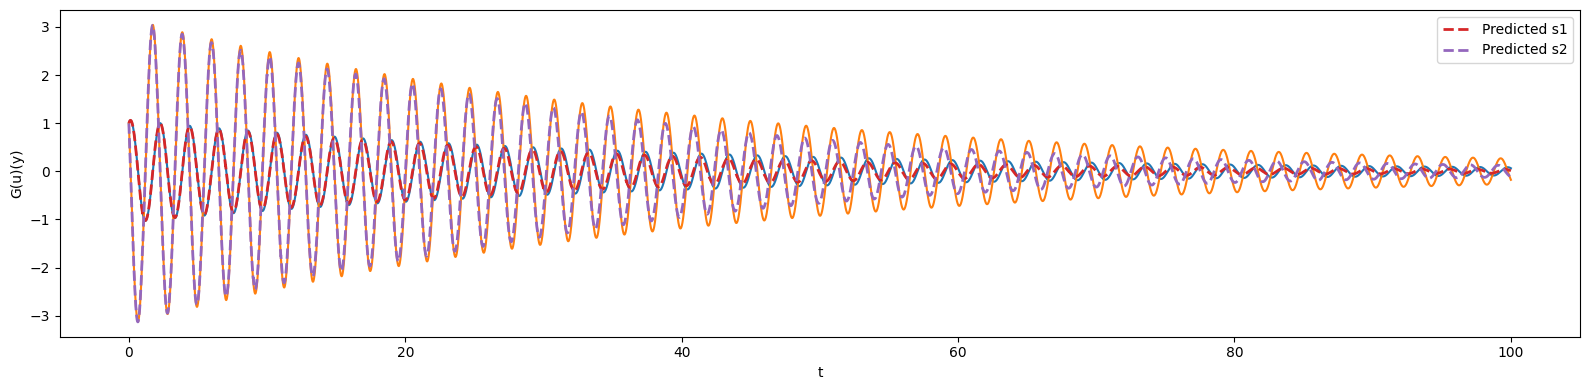

In [ ]:
# Plot
fig = plt.figure(figsize=(16,4))
plt.plot(y, s_exact[:,0], color='C0')
plt.plot(y, s_exact[:,1], color='C1')
plt.plot(y, s1_pred, '--', label='Predicted s1', lw=2, color='C3')
plt.plot(y, s2_pred, '--', label='Predicted s2', lw=2, color='C4')
plt.xlabel('y')
plt.ylabel('G(u)(y)')
plt.xlabel('t')
plt.tight_layout()
plt.legend()
plt.show()


# jax plot

In [ ]:
# Save PI-DeepONet model parameters and losses
flat_params, unravel  = ravel_pytree(model_jax.get_params(model_jax.opt_state))

# Restore PI-DeepONet model parameters
pendulum_params = unravel(flat_params)

# Create the test data
T = 100 # Final time
dt = 1.0
N = int(T / dt)

u0 = np.array([1.0, 1.0]) # initial state
y =  np.linspace(0, int(N * dt), int(100 * N))
s_exact = odeint(system, u0, y)

# Long time model prediction
P_test = 100
u0_star = np.tile(u0, (P_test, 1))
y_star = np.linspace(0, dt, P_test).reshape(-1, 1)

s1_pred_0, s2_pred_0 = model_jax.predict_s(pendulum_params, u0_star, y_star)
s1_pred = s1_pred_0
s2_pred = s2_pred_0

for k in range(1, N):
  u0 = np.hstack([s1_pred[-1], s2_pred[-1]])
  u_star = np.tile(u0, (P_test, 1))

  s1_pred_k, s2_pred_k = model_jax.predict_s(pendulum_params, u_star, y_star)

  s1_pred = np.hstack([s1_pred, s1_pred_k])
  s2_pred = np.hstack([s2_pred, s2_pred_k])

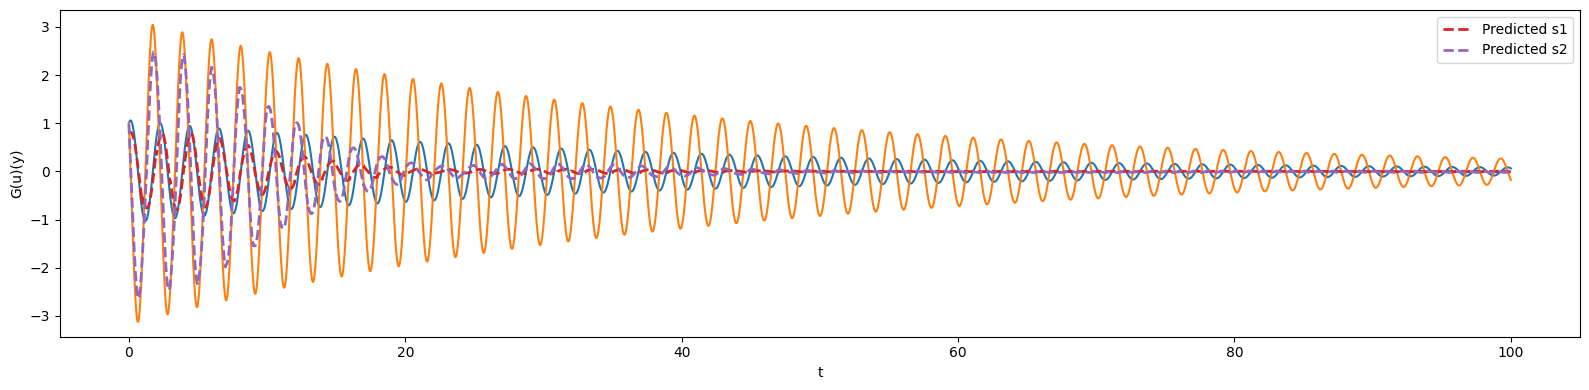

In [ ]:
# Plot
fig = plt.figure(figsize=(16,4))
plt.plot(y, s_exact[:,0], color='C0')
plt.plot(y, s_exact[:,1], color='C1')
plt.plot(y, s1_pred, '--', label='Predicted s1', lw=2, color='C3')
plt.plot(y, s2_pred, '--', label='Predicted s2', lw=2, color='C4')
plt.xlabel('y')
plt.ylabel('G(u)(y)')
plt.xlabel('t')
plt.tight_layout()
plt.legend()
plt.show()
